In [1]:
import sys
sys.path.append('../..')
from utils.workflow import WorkflowModel
from utils.data import RK4DataGenerator, stack_real_values, sin_beta, mono_beta, sin_beta_dfe, first_below_threshold
import utils.plotting as plotting
from utils.eval import eval_predictions, format_latex_table
import numpy as np

2026-02-17 15:02:38.831113: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-17 15:02:39.204086: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-17 15:02:40.759434: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


E0000 00:00:1771351362.682618  452348 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1771351362.691166  452348 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
t_0, t_f, N = 0, 50, 100
nop_data = 50
S0, I0, R0 = 99, 1, 0
noise_std = N * 0.00
gamma = 0.25
test_t = np.linspace(t_0, t_f, nop_data)
rkdata = RK4DataGenerator(sin_beta_dfe,
    gamma=gamma,
    t_0=t_0, 
    t_f=t_f, 
    N=N, 
    S0=S0, I0=I0, R0=R0
)
sir_real = rkdata.generate(test_t)
sir_data = rkdata.generate(test_t, noise_std)

In [3]:
sir_data[:,1]

array([ 1.        ,  1.60183782,  2.64570165,  4.41163304,  7.23987605,
       11.27207594, 16.17460218, 20.98256366, 24.7238025 , 26.7118833 ,
       27.11042711, 26.33051143, 24.7710299 , 22.81432129, 20.70209312,
       18.54722882, 16.42806834, 14.38327117, 12.42753508, 10.61228529,
        8.96369877,  7.49634522,  6.21611156,  5.12018875,  4.19741518,
        3.43198975,  2.80584157,  2.29871254,  1.88821138,  1.55411606,
        1.28235685,  1.06071765,  0.8785146 ,  0.72659605,  0.59851868,
        0.49126811,  0.40200665,  0.32808763,  0.26705818,  0.21698922,
        0.1764117 ,  0.14382551,  0.11774437,  0.09669876,  0.0795488 ,
        0.06558221,  0.05415892,  0.04472946,  0.03683739,  0.0302198 ])

In [4]:
dfe_value, dfe_point = first_below_threshold(sir_data[:,1], threshold=1)
dfe_value, dfe_point

(np.float64(0.8785145998856749), np.int64(32))

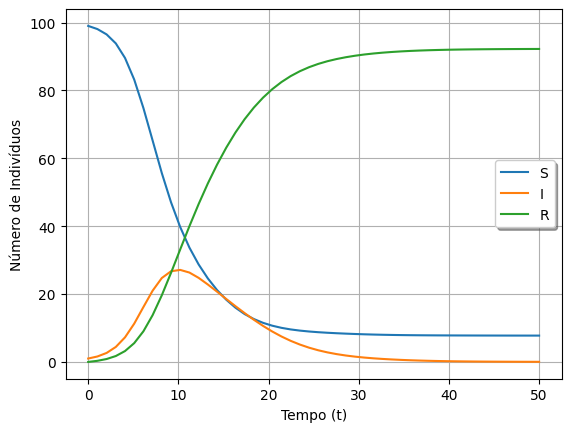

In [5]:
plotting.plot_rk_curves(test_t, sir_real)

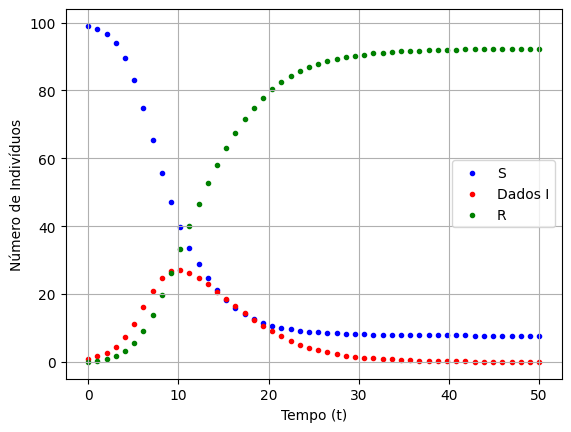

In [6]:
plotting.plot_rk_data(test_t, sir_data, 
    # vlines=[(dfe_point, "DFE", "red")], 
    figname="rk-data-dfe")

In [7]:
model = WorkflowModel(t_0, t_f, sir_data[:,1], test_t,
    N=N,
    gamma=gamma,
    beta_estimation_window=10,
    hidden_layer_size=40,
    n_hidden_layers=8,
    # w_physics=3000,
    scaling="min/max",
    activation="tanh",
    adam_iterations=500000,
    # parallel_pinns=True,
    estimate_beta=True,
    early_stopping=True,
    # adaptative_wdata=True,
    beta_hard_constraints=False,
    fine_tunning_using_lbfgs=False)
model.S0, model.I0, model.beta0

Compiling model...
'compile' took 0.005473 s



(np.float64(3.6558065763037195),
 np.float64(0.0358114024929788),
 np.float64(0.6343416635706239))

In [8]:
model.train()

Epoch 78300: early stopping


(<deepxde.model.LossHistory at 0x7f939685a110>,
 <deepxde.model.TrainState at 0x7f93b3f11290>)

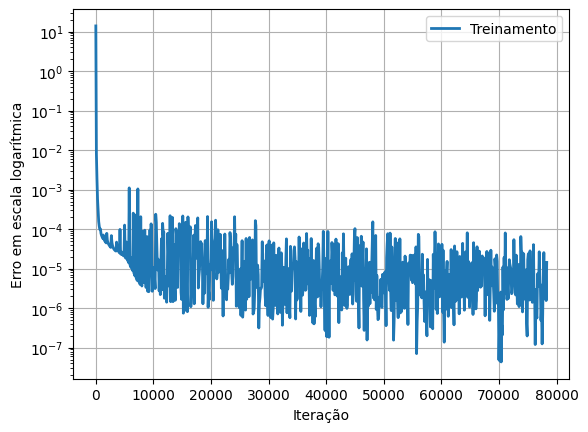

In [9]:
plotting.plot_losshistory(model.losshistory, "loss-dfe")

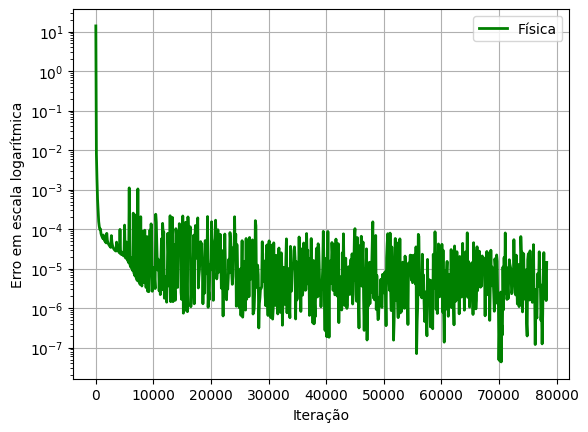

In [10]:
plotting.plot_phys_losshistory(model.losshistory, model.n_physics, "loss-physics-dfe")

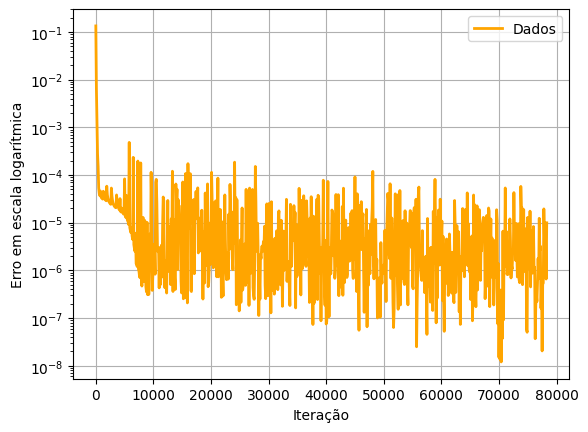

In [11]:
plotting.plot_data_losshistory(model.losshistory, "loss-data-dfe")

In [12]:
predictions = model.predict(test_t)

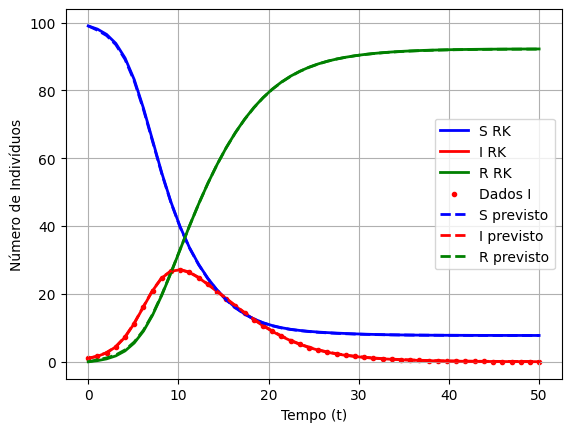

In [13]:
plotting.plot_results(sir_real, sir_data, predictions, test_t, N=N, 
    # vlines=[(dfe_point, "DFE", "purple")],
    figname="results-dfe")

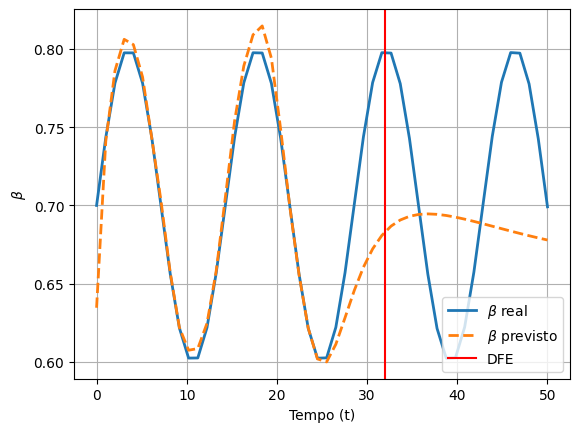

In [14]:
real_beta = sin_beta_dfe(test_t)
plotting.plot_beta_comparison(real_beta, predictions[:,2], test_t,
    vlines=[(dfe_point, "DFE", "red")],
    figname="predicted-beta-dfe" 
)

In [15]:
if model.data_weight_hist:
    plotting.plot_wdata(model.data_weight_hist)

In [16]:
real_values = stack_real_values(sir_real, real_beta)
metrics = eval_predictions(real_values, predictions)

In [17]:
metrics

,compartiment,RMSE,L2,L-infinity
0,S,0.153816,0.003961,0.413235
1,I,0.085547,0.007463,0.134308
2,beta,0.053858,0.075629,0.116797


In [18]:
format_latex_table(metrics)

'\\begin{tabular}{llrrr}\n\\toprule\n & compartiment & RMSE & L2 & L-infinity \\\\\n\\midrule\n0 & S & 0.153816 & 0.003961 & 0.413235 \\\\\n1 & I & 0.085547 & 0.007463 & 0.134308 \\\\\n2 & beta & 0.053858 & 0.075629 & 0.116797 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [19]:
model.formated_total_training_time

'00:03:02'